## Description of Notebook
How Can Machine Learning Help Us? We introduce a proof-of-concept model.

##### Risk Prediction Model
We use ML to predict whether a CitiBike trip is “high-risk” based on the features of the trip.

In [1]:
# libraries
import os
import sys
import numpy as np
from numpy import hstack
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score

In [2]:
# load datasets, CitiBike data is limited to 1million cause of computation cost
df_2023_cleaned = pd.read_csv('citibike_2023_cleaned.csv', nrows=1_000_000)
stations_sorted = pd.read_csv("stations_sorted.csv")

/tmp/ipykernel_3947580/100526948.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023_cleaned = pd.read_csv('citibike_2023_cleaned.csv', nrows=1_000_000)


In [4]:
# first we attach the risk score (accidents count) of each station 
# and nearest accident borough (already obtained previously) to each trip
# it matches based on the start_station_name

df = df_2023_cleaned.merge(
    stations_sorted[['start_station_name', 'accidents_within_150m', 'nearest_borough']],on='start_station_name', how='left')

In [6]:
# confirm every trip got matched
unmatched_acc_counts = df[df['accidents_within_150m'].isnull()]
unmatched_borough = df[df['nearest_borough'].isnull()]

print(f"Unmatched rows: {len(unmatched_acc_counts)}")
print(f"Unmatched rows: {len(unmatched_borough)}")

Unmatched rows: 0
Unmatched rows: 0


In [7]:
# define target by labeling top 20% most accident-prone stations as "risky"
# create a column with binary 1 or 0 (risky or not risky), Boolean turns to int

threshold = df['accidents_within_150m'].quantile(0.80)
df['is_risky'] = (df['accidents_within_150m'] >= threshold).astype(int)

In [8]:
# check for imbalance

df['is_risky'].value_counts(normalize=True)*100

0    79.028
1    20.972
Name: is_risky, dtype: float64

##### The dataset is a typical imbalanced scenario. Increasing the threshold (maybe 40%) might reduce class imbalance but now we will have more stations labeled as "risky", possibly diluting what "risky" really means. Essentially its a trade-off. We handle this by automatically adjusting weights inversely proportional to class frequencies (class_weight = balanced).

In [9]:
# define input features and target
features = ['ride_hour', 'ride_dayofweek',
            'ride_duration', 'ride_distance_km', 'member_casual', 'rideable_type', 'nearest_borough']
target = 'is_risky'

X = df[features]
Y = df[target]

In [10]:
# split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42, stratify=Y)

In [11]:
# preprocessing of features

categorical_features = ['ride_dayofweek', 'member_casual', 'rideable_type', 'nearest_borough']
numerical_features = ['ride_hour', 'ride_duration', 'ride_distance_km']

# encode categorical features - fits and transforms the columns into a one-hot encoded format
encoder = OneHotEncoder(handle_unknown='ignore', sparse=True)
X_train_cat = encoder.fit_transform(X_train[categorical_features])
X_test_cat = encoder.transform(X_test[categorical_features])

# standardizes (normalizes) numerical features so they are on the same scale
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])

# convert numeric arrays to sparse matrices
X_train_num_sparse = csr_matrix(X_train_num)
X_test_num_sparse = csr_matrix(X_test_num)

# combine all transformed features side by side
X_train_all = hstack([X_train_num_sparse, X_train_cat])
X_test_all = hstack([X_test_num_sparse, X_test_cat])

In [32]:
# plotting library
sys.path.append('/home/timi/Desktop/Timi/Data/AXA')
from plot_essentials import *

Precision: 0.275
Recall:    0.881
F1 Score: 0.419


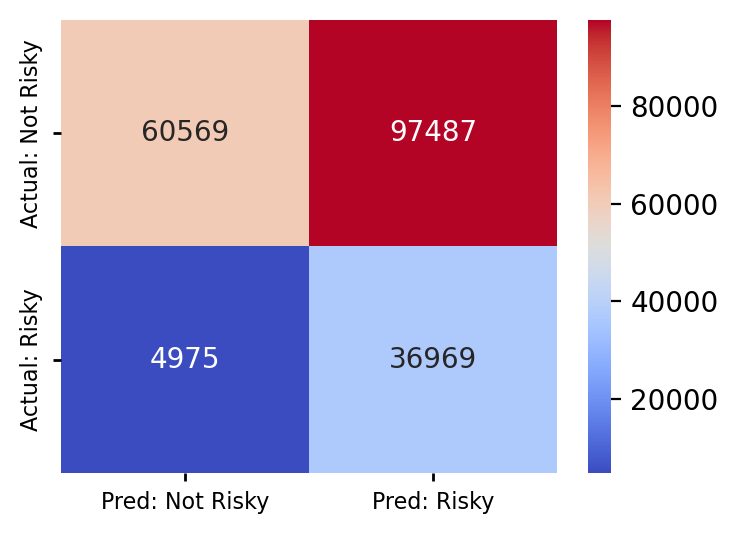

In [38]:
# declare logistic regression model and train the model

model = LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=1000, class_weight='balanced')

model.fit(X_train_all, Y_train)

# predictions
Y_pred = model.predict(X_test_all)

# model evaluation
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

cm = confusion_matrix(Y_test, Y_pred)
fig, ax = simple_plot_init([r'x', r'y'], font_size=10, figsize=[4,3], dpi=200)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',xticklabels=['Pred: Not Risky', 'Pred: Risky'], 
            yticklabels=['Actual: Not Risky', 'Actual: Risky'])
plt.tick_params(axis='x', which='minor', length=0)
plt.tick_params(axis='y', which='minor', length=0)

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Precision: 0.278
Recall:    0.868
F1 Score: 0.421


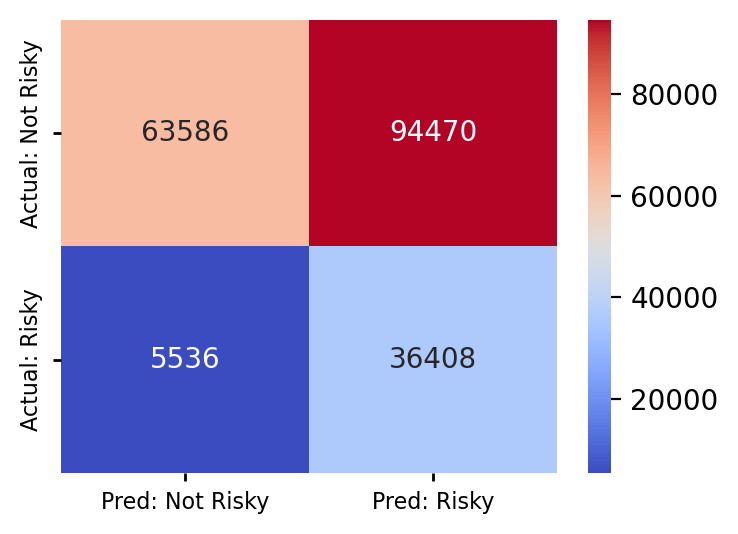

In [39]:
# declare randomforest model and train model

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=10,class_weight='balanced',random_state=42)

model.fit(X_train_all, Y_train)

# predictions
Y_pred = model.predict(X_test_all)

# model evaluation
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

cm = confusion_matrix(Y_test, Y_pred)
fig, ax = simple_plot_init([r'x', r'y'], font_size=10, figsize=[4,3], dpi=200)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',xticklabels=['Pred: Not Risky', 'Pred: Risky'], 
            yticklabels=['Actual: Not Risky', 'Actual: Risky'])
plt.tick_params(axis='x', which='minor', length=0)
plt.tick_params(axis='y', which='minor', length=0)

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score: {f1:.3f}")